In [2]:
import argparse
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import glob

from dcase_models.model.container import *
from dcase_models.data.data_generator import DataGenerator
from dcase_models.data.features import MelSpectrogram
from dcase_models.data.datasets import UrbanSound8k
from dcase_models.util.files import load_json, mkdir_if_not_exists, save_pickle, load_pickle
from dcase_models.util.data import evaluation_setup

sys.path.append('../')
from apnet.model import *
from apnet.layers import PrototypeLayer, WeightedSum

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
dataset_name = 'UrbanSound8k'
model_name = 'APNet'
features_name = 'MelSpectrogram'
fold_name = 'fold10'

In [5]:
# Get parameters
exp_path = '../experiments'
model_folder = os.path.join(exp_path, dataset_name, model_name)
parameters_file = os.path.join(model_folder, 'config.json')
params = load_json(parameters_file)
params_dataset = params['datasets'][dataset_name]
params_features = params['features'][features_name]
params_model = params['models'][model_name]

In [6]:
dataset_path = os.path.join(exp_path, params_dataset['dataset_path'])
dataset = UrbanSound8k(dataset_path)
dataset.check_if_downloaded()

True

In [7]:
features = MelSpectrogram(**params_features)
features.check_if_extracted(dataset)

True

In [9]:
exp_folder = os.path.join(model_folder, fold_name)
scaler = load_pickle(os.path.join(exp_folder, 'scaler.pickle'))

model_container = APNet(
    model=None, model_path=exp_folder, 
    custom_objects={
        'PrototypeLayer': PrototypeLayer,
        'WeightedSum': WeightedSum
    },
    metrics=['classification'],
    **params['models'][model_name]['model_arguments']
)
model_container.load_model_weights(exp_folder)
model_container.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 84, 128)      0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 21, 32, 32), 52096       input[0][0]                      
__________________________________________________________________________________________________
features (Lambda)               (None, 21, 32, 32)   0           encoder[1][0]                    
__________________________________________________________________________________________________
prototype_distances (PrototypeL (None, 50, 32)       1075200     features[0][0]                   
__________________________________________________________________________________________________
similarity

In [10]:
folds_train, folds_val, _ = evaluation_setup(
    fold_name, dataset.fold_list,
    params_dataset['evaluation_mode'],
    use_validate_set=True
)
data_gen = DataGenerator(
    dataset, features, folds=folds_train,
    batch_size=params['train']['batch_size'],
    shuffle=False, train=True, scaler=scaler
)

In [11]:
X, Y = data_gen.get_data()
print(X.shape, Y.shape)

(7022, 84, 128) (7022, 10)


In [12]:
#prototypes = load_pickle(os.path.join(exp_folder, 'prototypes.pickle'))
model_container.get_prototypes(X)
prototypes = model_container.prototypes
prototypes.sort()

save_pickle(prototypes, os.path.join(exp_folder, 'prototypes.pickle'))

Getting prototypes (spectrograms)...
Done!
Converting to audio...
Done!


[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 4 5 5 5 5 6 6 6 6 7 7 7
 7 7 7 8 8 8 8 8 9 9 9 9 9]


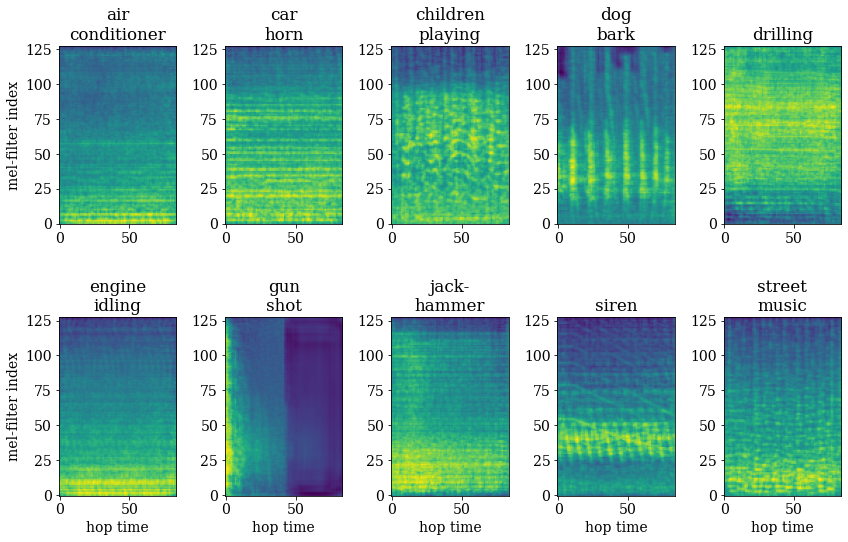

In [13]:
plt.rcParams.update({'font.size': 14, 'font.family': 'serif'})


class_names = (['air\nconditioner', 'car\nhorn', 'children\nplaying',
           'dog\nbark', 'drilling', 'engine\nidling', 'gun\nshot',
           'jack-\nhammer', 'siren', 'street\nmusic'])  

plt.figure(figsize=(12,8))
n_classes = len(dataset.label_list)

print(prototypes.classes)

ixs = [0, 5, 10, 15, 23, 26, 33, 38, 40, 45]

for j in range(n_classes):
    #print(prototypes.classes)
    #ix = np.argwhere(prototypes.classes == j)[0]
    ix = ixs[j]
    #print(ix)
    plt.subplot(2,n_classes/2,j+1)
    prototypej = np.squeeze(prototypes.mel_spectrograms[ix].T)
    plt.imshow(prototypej,origin='lower')
    plt.title(class_names[j])
    #plt.ylabel('mel-filter index')
    if (j==0) | (j==5):
        plt.ylabel('mel-filter index')
    if j in [5,6,7,8,9]:
        plt.xlabel('hop time')

plt.tight_layout()
plt.savefig('images/prototypes.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()    